In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import gc
import os
from tqdm import tqdm
pd.set_option('display.max_columns', 600)
pd.set_option('display.max_rows', 600)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [108]:
data_path = ''
data_train = pd.read_csv(data_path+'sensor_train.csv')
data_test = pd.read_csv(data_path+'sensor_test.csv')
data_test['fragment_id'] += 10000
label = 'behavior_id'

In [109]:
data = pd.concat([data_train, data_test], sort=False)
df = data.drop_duplicates(subset=['fragment_id']).reset_index(drop=True)[['fragment_id', 'behavior_id']]

data['acc'] = (data['acc_x'] ** 2 + data['acc_y'] ** 2 + data['acc_z'] ** 2) ** 0.5
data['accg'] = (data['acc_xg'] ** 2 + data['acc_yg'] ** 2 + data['acc_zg'] ** 2) ** 0.5
data['xy'] = (data['acc_x'] ** 2 + data['acc_y'] ** 2 ) ** 0.5
data['xy_g'] = (data['acc_xg'] ** 2 + data['acc_yg'] ** 2) ** 0.5

for f in tqdm([f for f in data.columns if 'acc' in f]):
    for stat in ['min', 'max', 'mean', 'median', 'std', 'skew']:
        df[f+'_'+stat] = data.groupby('fragment_id')[f].agg(stat).values
        
train_df = df[df[label].isna()==False].reset_index(drop=True)
test_df = df[df[label].isna()==True].reset_index(drop=True)

drop_feat = []
used_feat = [f for f in train_df.columns if f not in (['fragment_id', label] + drop_feat)]
print(len(used_feat))
print(used_feat)
scaler = MinMaxScaler()

train_x = train_df[used_feat]
train_y = train_df[label]
test_x = test_df[used_feat]

train_x[used_feat] = scaler.fit_transform(train_x)
test_x[used_feat] =scaler.transform(test_x)

100%|██████████| 8/8 [00:22<00:00,  2.77s/it]


48
['acc_x_min', 'acc_x_max', 'acc_x_mean', 'acc_x_median', 'acc_x_std', 'acc_x_skew', 'acc_y_min', 'acc_y_max', 'acc_y_mean', 'acc_y_median', 'acc_y_std', 'acc_y_skew', 'acc_z_min', 'acc_z_max', 'acc_z_mean', 'acc_z_median', 'acc_z_std', 'acc_z_skew', 'acc_xg_min', 'acc_xg_max', 'acc_xg_mean', 'acc_xg_median', 'acc_xg_std', 'acc_xg_skew', 'acc_yg_min', 'acc_yg_max', 'acc_yg_mean', 'acc_yg_median', 'acc_yg_std', 'acc_yg_skew', 'acc_zg_min', 'acc_zg_max', 'acc_zg_mean', 'acc_zg_median', 'acc_zg_std', 'acc_zg_skew', 'acc_min', 'acc_max', 'acc_mean', 'acc_median', 'acc_std', 'acc_skew', 'accg_min', 'accg_max', 'accg_mean', 'accg_median', 'accg_std', 'accg_skew']


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\pandas\core\frame.py:3395: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
C:\Anaconda3\lib\site-packages\pandas\core\frame.py:3367: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_array(key, value)
C:\Anaconda3\lib\site-packages

In [12]:
rf = RandomForestClassifier(oob_score=True, random_state=10,n_estimators=5000)

In [13]:
oof_train = np.zeros((len(train_x), 19))
preds = np.zeros((len(test_x), 19))
folds = 5
seeds = [44]#, 2020, 527, 1527]
for seed in seeds:
    kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    for fold, (trn_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):
        x_trn, y_trn, x_val, y_val = train_x.iloc[trn_idx], train_y.iloc[trn_idx], train_x.iloc[val_idx], train_y.iloc[val_idx]

        rf.fit(x_trn,y_trn)
        oof_train[val_idx] += rf.predict_proba(x_val) / len(seeds)
        preds += rf.predict_proba(test_x) / folds / len(seeds)
        #scores.append(model.best_score['valid_1']['multi_error'])
        #imp['gain' + str(fold + 1)] = model.feature_importance(importance_type='gain')
        #imp['split' + str(fold + 1)] = model.feature_importance(importance_type='split')
        del x_trn, y_trn, x_val, y_val
        gc.collect()

RandomForestClassifier(n_estimators=5000, oob_score=True, random_state=10)

383

RandomForestClassifier(n_estimators=5000, oob_score=True, random_state=10)

72

RandomForestClassifier(n_estimators=5000, oob_score=True, random_state=10)

72

RandomForestClassifier(n_estimators=5000, oob_score=True, random_state=10)

72

RandomForestClassifier(n_estimators=5000, oob_score=True, random_state=10)

72

In [9]:
def acc_combo(y, y_pred):
    # 数值ID与行为编码的对应关系
    mapping = {0: 'A_0', 1: 'A_1', 2: 'A_2', 3: 'A_3', 
        4: 'D_4', 5: 'A_5', 6: 'B_1',7: 'B_5', 
        8: 'B_2', 9: 'B_3', 10: 'B_0', 11: 'A_6', 
        12: 'C_1', 13: 'C_3', 14: 'C_0', 15: 'B_6', 
        16: 'C_2', 17: 'C_5', 18: 'C_6'}
    # 将行为ID转为编码
    code_y, code_y_pred = mapping[y], mapping[y_pred]
    if code_y == code_y_pred: #编码完全相同得分1.0
        return 1.0
    elif code_y.split("_")[0] == code_y_pred.split("_")[0]: #编码仅字母部分相同得分1.0/7
        return 1.0/7
    elif code_y.split("_")[1] == code_y_pred.split("_")[1]: #编码仅数字部分相同得分1.0/3
        return 1.0/3
    else:
        return 0.0

In [14]:
labels = np.argmax(preds, axis=1)
oof_y = np.argmax(oof_train, axis=1)

In [15]:
print(round(accuracy_score(train_y, oof_y), 5))
score = sum(acc_combo(y_true, y_pred) for y_true, y_pred in zip(train_y, oof_y)) / oof_y.shape[0]
print(round(score, 5))

0.72134
0.76185


In [18]:
oof_train

(7292, 19)

In [25]:
train_df[['fragment_id']].to_csv('oof_rf_prob.csv',index=False)

In [26]:
oof_rf_prob = pd.read_csv('oof_rf_prob.csv')

In [40]:
columns = [str(i)+'_proba' for i in range(19)]

In [42]:
for col in columns:
    oof_rf_prob[col] = np.nan

In [44]:
oof_rf_prob[columns] = oof_train

In [46]:
oof_rf_prob.to_csv('oof_rf_prob.csv',index=False)

In [47]:
oof_rf_prob_test = pd.read_csv('sub.csv')

In [50]:
oof_rf_prob_test.drop(['behavior_id'],inplace=True,axis=1)

In [52]:
for col in columns:
    oof_rf_prob_test[col] = np.nan

In [55]:
oof_rf_prob_test.to_csv('oof_rf_prob_test.csv',index=False)

In [123]:
scores = []
imp = pd.DataFrame()
imp['feat'] = used_feat

params = {
    'learning_rate': 0.02,
    'metric': 'multi_error',
    'objective': 'multiclass',
    'num_class': 19,
    'feature_fraction': 0.80,
    'bagging_fraction': 0.75,
    'bagging_freq': 2,
    'n_jobs': 4,
    'seed': 2020,
    'max_depth': 7,
    'num_leaves': 31,
    'lambda_l1': 0.7,
    'lambda_l2': 0.7,
}

oof_train = np.zeros((len(train_x), 19))
preds = np.zeros((len(test_x), 19))
folds = 5
seeds = [44]#, 2020, 527, 1527]
for seed in seeds:
    kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    for fold, (trn_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):
        x_trn, y_trn, x_val, y_val = train_x.iloc[trn_idx], train_y.iloc[trn_idx], train_x.iloc[val_idx], train_y.iloc[val_idx]
        train_set = lgb.Dataset(x_trn, y_trn)
        val_set = lgb.Dataset(x_val, y_val)

        model = lgb.train(params, train_set, num_boost_round=500000,
                          valid_sets=(train_set, val_set), early_stopping_rounds=50,
                          verbose_eval=20)
        oof_train[val_idx] += model.predict(x_val) / len(seeds)
        preds += model.predict(test_x) / folds / len(seeds)
        scores.append(model.best_score['valid_1']['multi_error'])
        imp['gain' + str(fold + 1)] = model.feature_importance(importance_type='gain')
        imp['split' + str(fold + 1)] = model.feature_importance(importance_type='split')
        del x_trn, y_trn, x_val, y_val, model, train_set, val_set
        gc.collect()

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.338934	valid_1's multi_error: 0.438657
[40]	training's multi_error: 0.250986	valid_1's multi_error: 0.385881
[60]	training's multi_error: 0.211726	valid_1's multi_error: 0.356408
[80]	training's multi_error: 0.181382	valid_1's multi_error: 0.349554
[100]	training's multi_error: 0.162181	valid_1's multi_error: 0.337903
[120]	training's multi_error: 0.145037	valid_1's multi_error: 0.32488
[140]	training's multi_error: 0.125493	valid_1's multi_error: 0.320082
[160]	training's multi_error: 0.108863	valid_1's multi_error: 0.318026
[180]	training's multi_error: 0.0925767	valid_1's multi_error: 0.311857
[200]	training's multi_error: 0.0792045	valid_1's multi_error: 0.307745
[220]	training's multi_error: 0.0666895	valid_1's multi_error: 0.305689
[240]	training's multi_error: 0.0564032	valid_1's multi_error: 0.305003
[260]	training's multi_error: 0.0469741	valid_1's multi_error: 0.302262
[280]	training's

444

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.327276	valid_1's multi_error: 0.438657
[40]	training's multi_error: 0.2455	valid_1's multi_error: 0.387252
[60]	training's multi_error: 0.209669	valid_1's multi_error: 0.379027
[80]	training's multi_error: 0.184982	valid_1's multi_error: 0.367375
[100]	training's multi_error: 0.161324	valid_1's multi_error: 0.358465
[120]	training's multi_error: 0.141951	valid_1's multi_error: 0.352296
[140]	training's multi_error: 0.127893	valid_1's multi_error: 0.344071
[160]	training's multi_error: 0.111092	valid_1's multi_error: 0.334476
[180]	training's multi_error: 0.0949769	valid_1's multi_error: 0.320768
[200]	training's multi_error: 0.0812618	valid_1's multi_error: 0.317341
[220]	training's multi_error: 0.0699469	valid_1's multi_error: 0.311172
[240]	training's multi_error: 0.0576033	valid_1's multi_error: 0.311857
[260]	training's multi_error: 0.0483456	valid_1's multi_error: 0.306374
[280]	training's 

42

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.331505	valid_1's multi_error: 0.435528
[40]	training's multi_error: 0.2494	valid_1's multi_error: 0.378601
[60]	training's multi_error: 0.214775	valid_1's multi_error: 0.358025
[80]	training's multi_error: 0.189921	valid_1's multi_error: 0.33882
[100]	training's multi_error: 0.168152	valid_1's multi_error: 0.337449
[120]	training's multi_error: 0.148783	valid_1's multi_error: 0.328532
[140]	training's multi_error: 0.127185	valid_1's multi_error: 0.317558
[160]	training's multi_error: 0.114501	valid_1's multi_error: 0.311385
[180]	training's multi_error: 0.0980459	valid_1's multi_error: 0.305898
[200]	training's multi_error: 0.0839904	valid_1's multi_error: 0.296982
[220]	training's multi_error: 0.0714775	valid_1's multi_error: 0.293553
[240]	training's multi_error: 0.0610216	valid_1's multi_error: 0.291495
[260]	training's multi_error: 0.0529654	valid_1's multi_error: 0.290123
[280]	training's m

280

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.322077	valid_1's multi_error: 0.419753
[40]	training's multi_error: 0.244086	valid_1's multi_error: 0.364198
[60]	training's multi_error: 0.21169	valid_1's multi_error: 0.349794
[80]	training's multi_error: 0.18735	valid_1's multi_error: 0.340192
[100]	training's multi_error: 0.164553	valid_1's multi_error: 0.32716
[120]	training's multi_error: 0.143469	valid_1's multi_error: 0.320988
[140]	training's multi_error: 0.124614	valid_1's multi_error: 0.305898
[160]	training's multi_error: 0.106616	valid_1's multi_error: 0.301783
[180]	training's multi_error: 0.0934179	valid_1's multi_error: 0.29561
[200]	training's multi_error: 0.0807336	valid_1's multi_error: 0.290809
[220]	training's multi_error: 0.0689064	valid_1's multi_error: 0.288752
[240]	training's multi_error: 0.0550223	valid_1's multi_error: 0.285322
[260]	training's multi_error: 0.0438807	valid_1's multi_error: 0.283951
[280]	training's mu

684

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.330305	valid_1's multi_error: 0.438957
[40]	training's multi_error: 0.250086	valid_1's multi_error: 0.391632
[60]	training's multi_error: 0.211862	valid_1's multi_error: 0.375171
[80]	training's multi_error: 0.189407	valid_1's multi_error: 0.358025
[100]	training's multi_error: 0.164038	valid_1's multi_error: 0.347051
[120]	training's multi_error: 0.144155	valid_1's multi_error: 0.335391
[140]	training's multi_error: 0.1289	valid_1's multi_error: 0.335391
[160]	training's multi_error: 0.111587	valid_1's multi_error: 0.323731
[180]	training's multi_error: 0.098903	valid_1's multi_error: 0.318244
[200]	training's multi_error: 0.0850189	valid_1's multi_error: 0.312071
[220]	training's multi_error: 0.072506	valid_1's multi_error: 0.309328
[240]	training's multi_error: 0.0613644	valid_1's multi_error: 0.305213
[260]	training's multi_error: 0.0515941	valid_1's multi_error: 0.303155
[280]	training's mu

352

In [124]:
labels = np.argmax(preds, axis=1)
oof_y = np.argmax(oof_train, axis=1)

print(round(accuracy_score(train_y, oof_y), 5))
score = sum(acc_combo(y_true, y_pred) for y_true, y_pred in zip(train_y, oof_y)) / oof_y.shape[0]
print(round(score, 5))

0.72175
0.76273


In [73]:
oof_lgb_prob = pd.read_csv('oof_rf_prob.csv')
oof_lgb_prob_test = pd.read_csv('oof_rf_prob_test.csv')
oof_rf_prob[columns] = oof_train
oof_lgb_prob_test[columns] = preds
oof_lgb_prob.to_csv('oof_lgb_prob.csv',index=False)
oof_lgb_prob_test.to_csv('oof_lgb_prob_test.csv',index=False)

In [120]:
knn = KNeighborsClassifier(n_neighbors=5)
oof_train = np.zeros((len(train_x), 19))
preds = np.zeros((len(test_x), 19))
folds = 5
seeds = [44]#, 2020, 527, 1527]
for seed in seeds:
    kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    for fold, (trn_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):
        x_trn, y_trn, x_val, y_val = train_x.iloc[trn_idx], train_y.iloc[trn_idx], train_x.iloc[val_idx], train_y.iloc[val_idx]

        knn.fit(x_trn,y_trn)
        oof_train[val_idx] += knn.predict_proba(x_val) / len(seeds)
        preds += knn.predict_proba(test_x) / folds / len(seeds)
        #scores.append(model.best_score['valid_1']['multi_error'])
        #imp['gain' + str(fold + 1)] = model.feature_importance(importance_type='gain')
        #imp['split' + str(fold + 1)] = model.feature_importance(importance_type='split')
        del x_trn, y_trn, x_val, y_val
        gc.collect()

KNeighborsClassifier()

48

KNeighborsClassifier()

48

KNeighborsClassifier()

48

KNeighborsClassifier()

48

KNeighborsClassifier()

48

In [121]:
labels = np.argmax(preds, axis=1)
oof_y = np.argmax(oof_train, axis=1)

print(round(accuracy_score(train_y, oof_y), 5))
score = sum(acc_combo(y_true, y_pred) for y_true, y_pred in zip(train_y, oof_y)) / oof_y.shape[0]
print(round(score, 5))

0.62562
0.67798


In [122]:
oof_knn_prob = pd.read_csv('oof_rf_prob.csv')
oof_knn_prob_test = pd.read_csv('oof_rf_prob_test.csv')
oof_knn_prob[columns] = oof_train
oof_knn_prob_test[columns] = preds
oof_knn_prob.to_csv('oof_knn_prob.csv',index=False)
oof_knn_prob_test.to_csv('oof_knn_prob_test.csv',index=False)

In [160]:
svc = SVC(kernel='linear',probability=True,C=100,gamma=10)
oof_train = np.zeros((len(train_x), 19))
preds = np.zeros((len(test_x), 19))
folds = 5
seeds = [44]#, 2020, 527, 1527]
for seed in seeds:
    kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    for fold, (trn_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):
        x_trn, y_trn, x_val, y_val = train_x.iloc[trn_idx], train_y.iloc[trn_idx], train_x.iloc[val_idx], train_y.iloc[val_idx]

        svc.fit(x_trn,y_trn)
        oof_train[val_idx] += svc.predict_proba(x_val) / len(seeds)
        preds += svc.predict_proba(test_x) / folds / len(seeds)
        #scores.append(model.best_score['valid_1']['multi_error'])
        #imp['gain' + str(fold + 1)] = model.feature_importance(importance_type='gain')
        #imp['split' + str(fold + 1)] = model.feature_importance(importance_type='split')
        del x_trn, y_trn, x_val, y_val
        gc.collect()

SVC(C=100, gamma=10, kernel='linear', probability=True)

0

SVC(C=100, gamma=10, kernel='linear', probability=True)

0

SVC(C=100, gamma=10, kernel='linear', probability=True)

0

SVC(C=100, gamma=10, kernel='linear', probability=True)

0

SVC(C=100, gamma=10, kernel='linear', probability=True)

0

In [161]:
labels = np.argmax(preds, axis=1)
oof_y = np.argmax(oof_train, axis=1)

print(round(accuracy_score(train_y, oof_y), 5))
score = sum(acc_combo(y_true, y_pred) for y_true, y_pred in zip(train_y, oof_y)) / oof_y.shape[0]
print(round(score, 5))

0.50192
0.57809


In [157]:
oof_svc_prob = pd.read_csv('oof_rf_prob.csv')
oof_svc_prob_test = pd.read_csv('oof_rf_prob_test.csv')
oof_svc_prob[columns] = oof_train
oof_svc_prob_test[columns] = preds
oof_svc_prob.to_csv('oof_svc_prob.csv',index=False)
oof_svc_prob_test.to_csv('oof_svc_prob_test.csv',index=False)

In [163]:
data1 = pd.merge(oof_rf_prob,oof_lgb_prob,on=['fragment_id'])

In [166]:
data1 =pd.merge(data1,oof_knn_prob,on=['fragment_id'])
data1 =pd.merge(data1,oof_svc_prob,on=['fragment_id'])

In [172]:
data1.head()

,fragment_id,0_proba_x,1_proba_x,2_proba_x,3_proba_x,4_proba_x,5_proba_x,6_proba_x,7_proba_x,8_proba_x,9_proba_x,10_proba_x,11_proba_x,12_proba_x,13_proba_x,14_proba_x,15_proba_x,16_proba_x,17_proba_x,18_proba_x,0_proba_y,1_proba_y,2_proba_y,3_proba_y,4_proba_y,5_proba_y,6_proba_y,7_proba_y,8_proba_y,9_proba_y,10_proba_y,11_proba_y,12_proba_y,13_proba_y,14_proba_y,15_proba_y,16_proba_y,17_proba_y,18_proba_y,0_proba_x,1_proba_x,2_proba_x,3_proba_x,4_proba_x,5_proba_x,6_proba_x,7_proba_x,8_proba_x,9_proba_x,10_proba_x,11_proba_x,12_proba_x,13_proba_x,14_proba_x,15_proba_x,16_proba_x,17_proba_x,18_proba_x,0_proba_y,1_proba_y,2_proba_y,3_proba_y,4_proba_y,5_proba_y,6_proba_y,7_proba_y,8_proba_y,9_proba_y,10_proba_y,11_proba_y,12_proba_y,13_proba_y,14_proba_y,15_proba_y,16_proba_y,17_proba_y,18_proba_y,0_proba_x,1_proba_x,2_proba_x,3_proba_x,4_proba_x,5_proba_x,6_proba_x,7_proba_x,8_proba_x,9_proba_x,10_proba_x,11_proba_x,12_proba_x,13_proba_x,14_proba_x,15_proba_x,16_proba_x,17_proba_x,18_proba_x,0_proba_y,1_proba_y,2_proba_y,3_proba_y,4_proba_y,5_proba_y,6_proba_y,7_proba_y,8_proba_y,9_proba_y,10_proba_y,11_proba_y,12_proba_y,13_proba_y,14_proba_y,15_proba_y,16_proba_y,17_proba_y,18_proba_y
0,0,0.031669,0.441127,0.001782,0.175464,0.002389,0.037579,0.063476,0.005356,0.002257,0.023875,0.175142,0.012161,0.003027,0.001950,0.000838,0.015173,0.001460,0.002880,0.002395,0.1024,0.3552,0.0002,0.0992,0.0002,0.0316,0.1304,0.0116,0.0034,0.0412,0.1276,0.0190,0.0092,0.0002,0.0000,0.0512,0.000,0.0162,0.0012,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020270,0.591118,0.001390,0.076698,0.001630,0.013208,0.015505,0.022670,0.001507,0.015394,0.148776,0.012079,0.002453,0.001991,0.001300,0.067546,0.001159,0.004001,0.001304,0.481034,0.374553,6.250838e-06,8.488125e-02,5.771121e-06,3.099303e-04,1.461453e-04,3.566003e-07,1.441350e-08,1.626174e-03,0.049993,6.524021e-03,1.115529e-06,1.644272e-05,9.510262e-08,8.849970e-04,1.559794e-05,1.518542e-06,1.312220e-06,0.276344,4.974163e-03,3.196806e-07,0.000028,3.635841e-06,4.885335e-03,4.949490e-08,1.744127e-07,9.497017e-12,5.787967e-05,0.713638,4.377463e-06,1.541949e-07,3.370034e-05,2.815372e-07,2.940170e-05,4.646852e-07,5.648534e-10,4.114973e-08
1,1,0.008463,0.881487,0.000831,0.017043,0.001019,0.021602,0.032368,0.001473,0.000847,0.016896,0.002923,0.004792,0.001404,0.000730,0.000418,0.004859,0.000707,0.001239,0.000899,0.0168,0.8154,0.0002,0.0350,0.0000,0.0498,0.0418,0.0016,0.0006,0.0166,0.0054,0.0076,0.0000,0.0006,0.0000,0.0074,0.000,0.0012,0.0000,0.0,0.8,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005188,0.845728,0.000357,0.038582,0.000395,0.014556,0.027319,0.000945,0.000409,0.032406,0.004537,0.025768,0.000484,0.000544,0.000331,0.000981,0.000295,0.000872,0.000305,0.573070,0.079127,2.785844e-07,2.294374e-05,1.792608e-04,7.888665e-06,9.447433e-06,4.797030e-06,6.715825e-10,1.557029e-01,0.191702,7.186552e-05,9.514194e-10,2.383866e-07,5.640025e-07,1.009518e-04,6.820856e-08,5.948169e-07,1.545804e-08,0.000562,8.662991e-01,1.819706e-09,0.007660,1.195446e-07,4.581188e-06,4.465006e-05,3.523876e-06,7.000848e-10,1.082985e-01,0.000297,1.673466e-02,1.676316e-08,1.725869e-06,1.140225e-05,7.543473e-05,3.884795e-07,6.601894e-06,2.564135e-07
2,2,0.093019,0.292943,0.002693,0.094578,0.003387,0.018731,0.081917,0.005751,0.002520,0.055956,0.206233,0.030800,0.004864,0.003710,0.001461,0.090085,0.002187,0.004168,0.004997,0.1746,0.1836,0.0006,0.1022,0.0010,0.0210,0.0746,0.0042,0.0024,0.0394,0.1270,0.0432,0.0176,0.0018,0.0042,0.1600,0.000,0.0328,0.0098,0.0,0.4,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.062659,0.253161,0.003676,0.216549,0.004394,0.026043,0.023008,0.014735,0.004070,0.054802,0.149235,0.032038,0.006927,0.004962,0.003788,0.057288,0.002972,0.075951,0.003743,0.806572,0.000636,2.580042e-06,6.057014e-02,1.033879e-04,2.398190e-04,2.423308e-07,3.745946e-06,6.820599e-07,4.296690e-03,0.085365,2.586398e-02,1.232927e-07,4.215697e-04,1.705838e-07,1.158001

In [173]:
oof_nn1_prob =pd.read_csv('oof_nn1_prob.csv')
oof_nn1_prob_test =pd.read_csv('oof_nn1_prob_test.csv')
oof_nn4_prob =pd.read_csv('oof_nn4_prob.csv')
oof_nn4_prob_test =pd.read_csv('oof_nn4_prob_test.csv')
oof_nn1_prob =pd.read_csv('oof_nn1_prob.csv')
oof_nn1_prob_test =pd.read_csv('oof_nn1_prob_test.csv')
oof_nn2_prob =pd.read_csv('oof_nn2_prob.csv')
oof_nn2_prob_test =pd.read_csv('oof_nn2_prob_test.csv')

In [170]:
data1 =pd.merge(data1,oof_nn1_prob,on=['fragment_id'])
data1 =pd.merge(data1,oof_nn4_prob,on=['fragment_id'])

In [174]:
data1 =pd.merge(data1,oof_nn2_prob,on=['fragment_id'])

In [184]:
data1.head()

,fragment_id,0_proba_x,1_proba_x,2_proba_x,3_proba_x,4_proba_x,5_proba_x,6_proba_x,7_proba_x,8_proba_x,9_proba_x,10_proba_x,11_proba_x,12_proba_x,13_proba_x,14_proba_x,15_proba_x,16_proba_x,17_proba_x,18_proba_x,0_proba_y,1_proba_y,2_proba_y,3_proba_y,4_proba_y,5_proba_y,6_proba_y,7_proba_y,8_proba_y,9_proba_y,10_proba_y,11_proba_y,12_proba_y,13_proba_y,14_proba_y,15_proba_y,16_proba_y,17_proba_y,18_proba_y,0_proba_x,1_proba_x,2_proba_x,3_proba_x,4_proba_x,5_proba_x,6_proba_x,7_proba_x,8_proba_x,9_proba_x,10_proba_x,11_proba_x,12_proba_x,13_proba_x,14_proba_x,15_proba_x,16_proba_x,17_proba_x,18_proba_x,0_proba_y,1_proba_y,2_proba_y,3_proba_y,4_proba_y,5_proba_y,6_proba_y,7_proba_y,8_proba_y,9_proba_y,10_proba_y,11_proba_y,12_proba_y,13_proba_y,14_proba_y,15_proba_y,16_proba_y,17_proba_y,18_proba_y,0_proba_x,1_proba_x,2_proba_x,3_proba_x,4_proba_x,5_proba_x,6_proba_x,7_proba_x,8_proba_x,9_proba_x,10_proba_x,11_proba_x,12_proba_x,13_proba_x,14_proba_x,15_proba_x,16_proba_x,17_proba_x,18_proba_x,0_proba_y,1_proba_y,2_proba_y,3_proba_y,4_proba_y,5_proba_y,6_proba_y,7_proba_y,8_proba_y,9_proba_y,10_proba_y,11_proba_y,12_proba_y,13_proba_y,14_proba_y,15_proba_y,16_proba_y,17_proba_y,18_proba_y,0_proba,1_proba,2_proba,3_proba,4_proba,5_proba,6_proba,7_proba,8_proba,9_proba,10_proba,11_proba,12_proba,13_proba,14_proba,15_proba,16_proba,17_proba,18_proba,behavior_id
0,0,0.031669,0.441127,0.001782,0.175464,0.002389,0.037579,0.063476,0.005356,0.002257,0.023875,0.175142,0.012161,0.003027,0.001950,0.000838,0.015173,0.001460,0.002880,0.002395,0.1024,0.3552,0.0002,0.0992,0.0002,0.0316,0.1304,0.0116,0.0034,0.0412,0.1276,0.0190,0.0092,0.0002,0.0000,0.0512,0.000,0.0162,0.0012,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020270,0.591118,0.001390,0.076698,0.001630,0.013208,0.015505,0.022670,0.001507,0.015394,0.148776,0.012079,0.002453,0.001991,0.001300,0.067546,0.001159,0.004001,0.001304,0.481034,0.374553,6.250838e-06,8.488125e-02,5.771121e-06,3.099303e-04,1.461453e-04,3.566003e-07,1.441350e-08,1.626174e-03,0.049993,6.524021e-03,1.115529e-06,1.644272e-05,9.510262e-08,8.849970e-04,1.559794e-05,1.518542e-06,1.312220e-06,0.276344,4.974163e-03,3.196806e-07,0.000028,3.635841e-06,4.885335e-03,4.949490e-08,1.744127e-07,9.497017e-12,5.787967e-05,0.713638,4.377463e-06,1.541949e-07,3.370034e-05,2.815372e-07,2.940170e-05,4.646852e-07,5.648534e-10,4.114973e-08,0.943114,0.014947,2.832391e-07,3.168322e-02,8.313984e-07,4.897588e-04,2.101600e-08,5.589885e-07,1.111513e-09,5.037563e-03,4.688866e-03,2.013336e-05,2.677102e-10,1.379965e-06,6.209310e-07,1.455863e-05,1.057558e-07,4.065118e-07,5.204594e-07,0.0
1,1,0.008463,0.881487,0.000831,0.017043,0.001019,0.021602,0.032368,0.001473,0.000847,0.016896,0.002923,0.004792,0.001404,0.000730,0.000418,0.004859,0.000707,0.001239,0.000899,0.0168,0.8154,0.0002,0.0350,0.0000,0.0498,0.0418,0.0016,0.0006,0.0166,0.0054,0.0076,0.0000,0.0006,0.0000,0.0074,0.000,0.0012,0.0000,0.0,0.8,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005188,0.845728,0.000357,0.038582,0.000395,0.014556,0.027319,0.000945,0.000409,0.032406,0.004537,0.025768,0.000484,0.000544,0.000331,0.000981,0.000295,0.000872,0.000305,0.573070,0.079127,2.785844e-07,2.294374e-05,1.792608e-04,7.888665e-06,9.447433e-06,4.797030e-06,6.715825e-10,1.557029e-01,0.191702,7.186552e-05,9.514194e-10,2.383866e-07,5.640025e-07,1.009518e-04,6.820856e-08,5.948169e-07,1.545804e-08,0.000562,8.662991e-01,1.819706e-09,0.007660,1.195446e-07,4.581188e-06,4.465006e-05,3.523876e-06,7.000848e-10,1.082985e-01,0.000297,1.673466e-02,1.676316e-08,1.725869e-06,1.140225e-05,7.543473e-05,3.884795e-07,6.601894e-06,2.564135e-07,0.008326,0.968507,5.522135e-08,3.101615e-08,1.772393e-02,3.026936e-08,2.151280e-08,1.092184e-07,9.782048e-09,3.087210e-03,2.351299e-03,4.590864e-06,7.544784e-15,2.370737e-11,6.984537e-11,4.949271e-07,1.316929e-11,1.755843e-09,4.897525e-14,0.0
2,2,0.093019,0.292943,0.002693,0.094578,0.003387,0.018731,0.081917,0.005751,0.002520,0

In [179]:
train_x.head()

,acc_x_min,acc_x_max,acc_x_mean,acc_x_median,acc_x_std,acc_x_skew,acc_y_min,acc_y_max,acc_y_mean,acc_y_median,acc_y_std,acc_y_skew,acc_z_min,acc_z_max,acc_z_mean,acc_z_median,acc_z_std,acc_z_skew,acc_xg_min,acc_xg_max,acc_xg_mean,acc_xg_median,acc_xg_std,acc_xg_skew,acc_yg_min,acc_yg_max,acc_yg_mean,acc_yg_median,acc_yg_std,acc_yg_skew,acc_zg_min,acc_zg_max,acc_zg_mean,acc_zg_median,acc_zg_std,acc_zg_skew,acc_min,acc_max,acc_mean,acc_median,acc_std,acc_skew,accg_min,accg_max,accg_mean,accg_median,accg_std,accg_skew
0,0.920000,0.011594,0.413926,0.542373,0.039158,0.401678,0.979592,0.022222,0.390096,0.294118,0.023771,0.467862,0.929134,0.024823,0.592247,0.60,0.069515,0.510347,0.659933,0.255155,0.515841,0.518135,0.029712,0.438977,0.800752,0.555556,0.722787,0.719780,0.025638,0.518347,0.860963,0.307692,0.862863,0.898955,0.059745,0.495878,0.000000,0.027435,0.052375,0.043145,0.047137,0.248385,0.843662,0.028872,0.190793,0.340451,0.056427,0.496838
1,0.946667,0.005797,0.405896,0.542373,0.022183,0.412803,0.993197,0.022222,0.396795,0.294118,0.016324,0.528035,0.952756,0.021277,0.621546,0.65,0.043564,0.539036,0.680135,0.247423,0.515912,0.518135,0.018729,0.484943,0.808271,0.550725,0.725878,0.719780,0.019945,0.526566,0.909091,0.310096,0.863612,0.898955,0.042599,0.617168,0.000000,0.020538,0.034727,0.027287,0.030781,0.311711,0.931695,0.027672,0.211447,0.342910,0.038872,0.622006
2,0.946667,0.020290,0.404836,0.542373,0.048338,0.531610,0.959184,0.022222,0.389272,0.294118,0.038021,0.394404,0.889764,0.042553,0.600464,0.60,0.093684,0.476425,0.673401,0.268041,0.521830,0.518135,0.050443,0.553230,0.800752,0.565217,0.732549,0.725275,0.037898,0.494730,0.860963,0.319712,0.855009,0.891986,0.076404,0.542749,0.000000,0.043521,0.067668,0.047263,0.066111,0.346175,0.864244,0.036568,0.194364,0.363272,0.068343,0.530991
3,0.953333,0.014493,0.415161,0.542373,0.036107,0.504666,0.979592,0.037037,0.396056,0.294118,0.033806,0.572743,0.929134,0.060284,0.627781,0.60,0.117153,0.628434,0.646465,0.252577,0.502066,0.502591,0.047466,0.461912,0.804511,0.570048,0.737811,0.730769,0.031685,0.496472,0.877005,0.312500,0.851240,0.885017,0.073086,0.584750,0.000000,0.051527,0.074492,0.054574,0.077935,0.356956,0.864739,0.029621,0.180501,0.336686,0.069349,0.559849
4,0.893333,0.026087,0.415161,0.542373,0.068191,0.450772,0.965986,0.051852,0.391361,0.294118,0.053467,0.529983,0.858268,0.063830,0.600103,0.65,0.166556,0.529148,0.649832,0.260309,0.512318,0.518135,0.062259,0.489646,0.774436,0.560386,0.715791,0.714286,0.047943,0.475288,0.786096,0.334135,0.866266,0.905923,0.132888,0.505414,0.084365,0.054263,0.124296,0.105683,0.092122,0.247648,0.758629,0.057496,0.187294,0.359235,0.120903,0.542701


In [181]:
train_y.shape

(7292,)

In [182]:
train_df.head()

,fragment_id,behavior_id,acc_x_min,acc_x_max,acc_x_mean,acc_x_median,acc_x_std,acc_x_skew,acc_y_min,acc_y_max,acc_y_mean,acc_y_median,acc_y_std,acc_y_skew,acc_z_min,acc_z_max,acc_z_mean,acc_z_median,acc_z_std,acc_z_skew,acc_xg_min,acc_xg_max,acc_xg_mean,acc_xg_median,acc_xg_std,acc_xg_skew,acc_yg_min,acc_yg_max,acc_yg_mean,acc_yg_median,acc_yg_std,acc_yg_skew,acc_zg_min,acc_zg_max,acc_zg_mean,acc_zg_median,acc_zg_std,acc_zg_skew,acc_min,acc_max,acc_mean,acc_median,acc_std,acc_skew,accg_min,accg_max,accg_mean,accg_median,accg_std,accg_skew
0,0,0.0,-0.9,0.4,-0.001754,0.0,0.194102,-1.523203,-0.3,0.2,-0.001754,-0.0,0.085547,-0.497876,-0.8,0.7,0.003509,-0.0,0.294573,-0.283199,-0.2,1.3,0.677193,0.7,0.200016,-0.909003,4.4,5.2,4.773684,4.8,0.158707,0.284234,7.2,9.3,8.508772,8.5,0.338738,-0.746650,0.000000,0.953939,0.281656,0.223607,0.225918,1.141795,8.635392,10.560776,9.784581,9.786726,0.293469,-0.677138
1,1,0.0,-0.5,0.2,-0.025000,-0.0,0.109959,-1.350853,-0.1,0.2,0.026786,0.0,0.058748,0.434311,-0.5,0.6,0.078571,0.1,0.184602,0.129004,0.4,1.0,0.678571,0.7,0.126080,-0.199871,4.6,5.1,4.830357,4.8,0.123465,0.411559,8.1,9.4,8.519643,8.5,0.241525,0.917398,0.000000,0.714143,0.186749,0.141421,0.147525,1.626938,9.441398,10.521407,9.819616,9.791067,0.202188,1.053017
2,2,0.0,-0.5,0.7,-0.028070,-0.0,0.239609,0.489693,-0.6,0.2,-0.005263,0.0,0.136828,-1.635879,-1.3,1.2,0.024561,0.0,0.396989,-0.770588,0.2,1.8,0.792982,0.7,0.339569,0.853589,4.4,5.4,4.952632,4.9,0.234601,-0.081638,7.2,9.8,8.394737,8.4,0.433186,-0.103604,0.000000,1.513275,0.363894,0.244949,0.316852,1.890966,8.823831,10.813418,9.790638,9.827004,0.355424,-0.205059
3,3,0.0,-0.4,0.5,0.001818,0.0,0.178980,0.072280,-0.3,0.4,0.023636,-0.0,0.121661,1.126930,-0.8,1.7,0.094545,0.0,0.496438,1.413450,-0.6,1.2,0.410909,0.4,0.319532,-0.555181,4.5,5.5,5.049091,5.0,0.196141,-0.054651,7.5,9.5,8.340000,8.3,0.414371,0.472631,0.000000,1.791647,0.400589,0.282843,0.373524,1.973559,8.828363,10.585367,9.767121,9.780082,0.360655,0.193839
4,4,0.0,-1.3,0.9,0.001818,0.0,0.338018,-0.762639,-0.5,0.6,0.003636,0.0,0.192415,0.464490,-1.7,1.8,0.023636,0.1,0.705787,-0.013071,-0.5,1.5,0.609091,0.7,0.419114,-0.127315,3.7,5.3,4.645455,4.7,0.296784,-0.382833,5.8,10.4,8.558182,8.6,0.753434,-0.615809,0.141421,1.886796,0.668420,0.547723,0.441521,1.136149,7.856844,11.500435,9.778645,9.819878,0.628718,-0.043196


In [183]:
data1['behavior_id'] = train_y

In [204]:
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.backend import expand_dims

In [211]:
def Net():
    input_data = Input(shape=(133,)) 
    X = Dense(128,activation='relu')(input_data)
    X = Dense(19,activation='softmax')(X)
    return Model([input_data], X)

In [192]:
stk_test = pd.merge(oof_knn_prob_test,oof_lgb_prob_test,on=['fragment_id'])
stk_test = pd.merge(stk_test,oof_nn1_prob_test,on=['fragment_id'])
stk_test = pd.merge(stk_test,oof_nn2_prob_test,on=['fragment_id'])
stk_test = pd.merge(stk_test,oof_nn4_prob_test,on=['fragment_id'])
stk_test = pd.merge(stk_test,oof_rf_prob_test,on=['fragment_id'])
stk_test = pd.merge(stk_test,oof_svc_prob_test,on=['fragment_id'])

In [193]:
stk_test.shape

(7500, 134)

In [221]:
x = data1.drop(['fragment_id','behavior_id'],axis=1)
y = data1['behavior_id']
t = stk_test.drop(['fragment_id'],axis=1)

In [223]:
nn_proba_sub = np.zeros((7500, 19))
nn_proba_val = np.zeros((7292, 19))
for fold, (trn_idx, val_idx) in enumerate(kfold.split(x, y)):
    y_ = to_categorical(y, num_classes=19)
    model = Net()
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['acc'])
    plateau = ReduceLROnPlateau(monitor="val_acc",
                                verbose=0,
                                mode='auto',
                                factor=1. / np.cbrt(2),
                                patience=200)
    early_stopping = EarlyStopping(monitor='val_acc',
                                   verbose=0,
                                   mode='auto',
                                   patience=200)
    checkpoint = ModelCheckpoint(f'fold{fold}.h5',
                                 monitor='val_acc',
                                 verbose=0,
                                 mode='auto',
                                 save_best_only=True)
    model.fit(x.iloc[trn_idx], y_[trn_idx],
              epochs=1000,
              batch_size=512,
              verbose=1,
              shuffle=True,
              validation_data=(x.iloc[val_idx], y_[val_idx]),
              callbacks=[plateau, early_stopping, checkpoint])
    model.load_weights(f'fold{fold}.h5')
    nn_proba_sub += model.predict(t, verbose=0, batch_size=1024) / 5.
    nn_proba_val[val_idx] = model.predict(x.iloc[val_idx]) 

Epoch 1/1000
12/12 [==============================] - ETA: 0s - loss: 2.9303 - acc: 0.025 - ETA: 0s - loss: 2.7641 - acc: 0.363 - 3s 217ms/step - loss: 2.7388 - acc: 0.3986 - val_loss: 2.4999 - val_acc: 0.6813 - lr: 0.0010
Epoch 2/1000
12/12 [==============================] - ETA: 0s - loss: 2.5172 - acc: 0.656 - ETA: 0s - loss: 2.3674 - acc: 0.740 - 1s 75ms/step - loss: 2.3123 - acc: 0.7495 - val_loss: 2.0657 - val_acc: 0.8122 - lr: 0.0010
Epoch 3/1000
12/12 [==============================] - ETA: 0s - loss: 2.0950 - acc: 0.794 - ETA: 0s - loss: 1.9306 - acc: 0.813 - 1s 75ms/step - loss: 1.8599 - acc: 0.8155 - val_loss: 1.6076 - val_acc: 0.8232 - lr: 0.0010
Epoch 4/1000
12/12 [==============================] - ETA: 0s - loss: 1.5667 - acc: 0.832 - ETA: 0s - loss: 1.4457 - acc: 0.827 - 1s 73ms/step - loss: 1.4092 - acc: 0.8280 - val_loss: 1.1968 - val_acc: 0.8286 - lr: 0.0010
Epoch 5/1000
12/12 [==============================] - ETA: 0s - loss: 1.1697 - acc: 0.835 - ETA: 0s - loss: 1.0

KeyboardInterrupt: 

In [201]:
x.head()

,0_proba_x,1_proba_x,2_proba_x,3_proba_x,4_proba_x,5_proba_x,6_proba_x,7_proba_x,8_proba_x,9_proba_x,10_proba_x,11_proba_x,12_proba_x,13_proba_x,14_proba_x,15_proba_x,16_proba_x,17_proba_x,18_proba_x,0_proba_y,1_proba_y,2_proba_y,3_proba_y,4_proba_y,5_proba_y,6_proba_y,7_proba_y,8_proba_y,9_proba_y,10_proba_y,11_proba_y,12_proba_y,13_proba_y,14_proba_y,15_proba_y,16_proba_y,17_proba_y,18_proba_y,0_proba_x,1_proba_x,2_proba_x,3_proba_x,4_proba_x,5_proba_x,6_proba_x,7_proba_x,8_proba_x,9_proba_x,10_proba_x,11_proba_x,12_proba_x,13_proba_x,14_proba_x,15_proba_x,16_proba_x,17_proba_x,18_proba_x,0_proba_y,1_proba_y,2_proba_y,3_proba_y,4_proba_y,5_proba_y,6_proba_y,7_proba_y,8_proba_y,9_proba_y,10_proba_y,11_proba_y,12_proba_y,13_proba_y,14_proba_y,15_proba_y,16_proba_y,17_proba_y,18_proba_y,0_proba_x,1_proba_x,2_proba_x,3_proba_x,4_proba_x,5_proba_x,6_proba_x,7_proba_x,8_proba_x,9_proba_x,10_proba_x,11_proba_x,12_proba_x,13_proba_x,14_proba_x,15_proba_x,16_proba_x,17_proba_x,18_proba_x,0_proba_y,1_proba_y,2_proba_y,3_proba_y,4_proba_y,5_proba_y,6_proba_y,7_proba_y,8_proba_y,9_proba_y,10_proba_y,11_proba_y,12_proba_y,13_proba_y,14_proba_y,15_proba_y,16_proba_y,17_proba_y,18_proba_y,0_proba,1_proba,2_proba,3_proba,4_proba,5_proba,6_proba,7_proba,8_proba,9_proba,10_proba,11_proba,12_proba,13_proba,14_proba,15_proba,16_proba,17_proba,18_proba
0,0.031669,0.441127,0.001782,0.175464,0.002389,0.037579,0.063476,0.005356,0.002257,0.023875,0.175142,0.012161,0.003027,0.001950,0.000838,0.015173,0.001460,0.002880,0.002395,0.1024,0.3552,0.0002,0.0992,0.0002,0.0316,0.1304,0.0116,0.0034,0.0412,0.1276,0.0190,0.0092,0.0002,0.0000,0.0512,0.000,0.0162,0.0012,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020270,0.591118,0.001390,0.076698,0.001630,0.013208,0.015505,0.022670,0.001507,0.015394,0.148776,0.012079,0.002453,0.001991,0.001300,0.067546,0.001159,0.004001,0.001304,0.481034,0.374553,6.250838e-06,8.488125e-02,5.771121e-06,3.099303e-04,1.461453e-04,3.566003e-07,1.441350e-08,1.626174e-03,0.049993,6.524021e-03,1.115529e-06,1.644272e-05,9.510262e-08,8.849970e-04,1.559794e-05,1.518542e-06,1.312220e-06,0.276344,4.974163e-03,3.196806e-07,0.000028,3.635841e-06,4.885335e-03,4.949490e-08,1.744127e-07,9.497017e-12,5.787967e-05,0.713638,4.377463e-06,1.541949e-07,3.370034e-05,2.815372e-07,2.940170e-05,4.646852e-07,5.648534e-10,4.114973e-08,0.943114,0.014947,2.832391e-07,3.168322e-02,8.313984e-07,4.897588e-04,2.101600e-08,5.589885e-07,1.111513e-09,5.037563e-03,4.688866e-03,2.013336e-05,2.677102e-10,1.379965e-06,6.209310e-07,1.455863e-05,1.057558e-07,4.065118e-07,5.204594e-07
1,0.008463,0.881487,0.000831,0.017043,0.001019,0.021602,0.032368,0.001473,0.000847,0.016896,0.002923,0.004792,0.001404,0.000730,0.000418,0.004859,0.000707,0.001239,0.000899,0.0168,0.8154,0.0002,0.0350,0.0000,0.0498,0.0418,0.0016,0.0006,0.0166,0.0054,0.0076,0.0000,0.0006,0.0000,0.0074,0.000,0.0012,0.0000,0.0,0.8,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005188,0.845728,0.000357,0.038582,0.000395,0.014556,0.027319,0.000945,0.000409,0.032406,0.004537,0.025768,0.000484,0.000544,0.000331,0.000981,0.000295,0.000872,0.000305,0.573070,0.079127,2.785844e-07,2.294374e-05,1.792608e-04,7.888665e-06,9.447433e-06,4.797030e-06,6.715825e-10,1.557029e-01,0.191702,7.186552e-05,9.514194e-10,2.383866e-07,5.640025e-07,1.009518e-04,6.820856e-08,5.948169e-07,1.545804e-08,0.000562,8.662991e-01,1.819706e-09,0.007660,1.195446e-07,4.581188e-06,4.465006e-05,3.523876e-06,7.000848e-10,1.082985e-01,0.000297,1.673466e-02,1.676316e-08,1.725869e-06,1.140225e-05,7.543473e-05,3.884795e-07,6.601894e-06,2.564135e-07,0.008326,0.968507,5.522135e-08,3.101615e-08,1.772393e-02,3.026936e-08,2.151280e-08,1.092184e-07,9.782048e-09,3.087210e-03,2.351299e-03,4.590864e-06,7.544784e-15,2.370737e-11,6.984537e-11,4.949271e-07,1.316929e-11,1.755843e-09,4.897525e-14
2,0.093019,0.292943,0.002693,0.094578,0.003387,0.018731,0.081917,0.005751,0.002520,0.055956,0.206233,0.030800,0.004864,0.0

In [218]:
for fold, (trn_idx, val_idx) in enumerate(kfold.split(x, y_)):
    # = to_categorical(y, num_classes=19)
    print(y.iloc[trn_idx])
    break

1        0.0
3        0.0
4        0.0
6        0.0
7        0.0
8        0.0
9        0.0
12       0.0
14       0.0
15       0.0
16       0.0
17       0.0
18       0.0
19       0.0
20       0.0
21       0.0
23       0.0
27       0.0
28       0.0
29       0.0
30       0.0
33       0.0
35       0.0
37       0.0
38       0.0
40       0.0
41       0.0
42       0.0
43       0.0
44       0.0
45       0.0
46       0.0
47       0.0
48       0.0
49       0.0
50       0.0
51       0.0
52       0.0
53       0.0
54       0.0
55       0.0
57       0.0
59       0.0
60       0.0
61       0.0
64       0.0
66       0.0
67       0.0
68       0.0
69       0.0
70       0.0
71       0.0
72       0.0
73       0.0
74       0.0
75       0.0
77       0.0
78       0.0
79       0.0
80       0.0
81       0.0
82       0.0
84       0.0
86       0.0
87       0.0
88       0.0
89       0.0
90       0.0
91       0.0
93       0.0
95       0.0
97       0.0
98       0.0
99       0.0
101      0.0
102      0.0
103      0.0

In [217]:
type(y_)

pandas.core.series.Series

In [2]:
from sklearn.datasets import load_boston

In [8]:
boston = load_boston(return_X_y=True)

In [6]:
X

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])

In [10]:
from sklearn import datasets
import pandas as pd

boston_data = datasets.load_boston()
df_boston = pd.DataFrame(boston_data.data,columns=boston_data.feature_names)
df_boston['target'] = pd.Series(boston_data.target)
df_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [11]:
import seaborn as sns



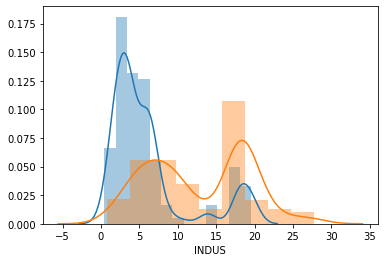

In [14]:
sns.distplot(df_boston.loc[df_boston['target']>25,'INDUS'])
sns.distplot(df_boston.loc[df_boston['target']<=25,'INDUS'])

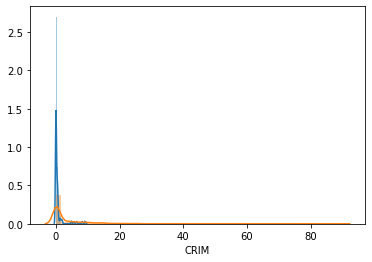

In [18]:
sns.distplot(df_boston.loc[df_boston['target']>30,'CRIM'])
sns.distplot(df_boston.loc[df_boston['target']<=30,'CRIM'])

In [48]:
import torch

In [19]:
import scipy.stats
def JS_divergence(p,q):
    M=(p+q)/2
    return 0.5*scipy.stats.entropy(p, M)+0.5*scipy.stats.entropy(q, M)

In [44]:
print(JS_divergence(df_boston['target'],df_boston['target'].sample(frac=1)))

0.07926668754001932


In [45]:
def KL_divergence(p,q):
    return scipy.stats.entropy(p, q)

In [47]:
print(KL_divergence(df_boston['target'],df_boston['target'].sample(frac=1)))

0.1512329814093707


In [50]:
input = torch.tensor(df_boston['target'])
target = torch.tensor(df_boston['target'].sample(frac=1))

In [52]:
torch.nn.functional.kl_div(input, input, size_average=None, reduce=None, reduction='mean')

C:\Users\A\anaconda3\lib\site-packages\torch\nn\functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


tensor(-520.1946, dtype=torch.float64)

In [56]:
torch.distributions.kl.kl_divergence(torch.tensor([1.,2.,3.]),torch.tensor([1.,2.,3.]))

NotImplementedError: 